In [33]:
# Import the necessary libraries
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from google.cloud import storage

In [34]:
# Create a client object for the GCP storage bucket
storage_client = storage.Client()
bucket = storage_client.get_bucket('cchighdtraffic')

# List all the files in the bucket
blobs = bucket.list_blobs()

# Create a list to store the dataframes
dfs = []

# Loop over each file in the bucket
for blob in blobs:
    if blob.name.startswith('data/') and blob.name.endswith('_recordingMeta.csv'):
        blob_bytes = blob.download_as_bytes()
        df = pd.read_csv(BytesIO(blob_bytes))
        dfs.append(df)

# Concatenate all the dataframes into a single dataframe
f = pd.concat(dfs, ignore_index=True)

In [35]:
# For this part we filtered all of the neccessary parameters we need to process.
df = f.loc[:, ['locationId','weekDay','startTime', 'duration', 'numVehicles', 'totalDrivenDistance', 'totalDrivenTime']]
# We have different Autobahn so we just chose one for the processing to see what is happening.
df = df[df['locationId'] == 1]
# We added another column to the dataset since we it is easier to process the weekdays as numebers.
weekday_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
df['weekDayNum'] = df['weekDay'].map(weekday_map)

In [36]:
# Exporting the Dataset into .csv file. The output will change through the code but the metadata.csv is what we gathered
# using the GCP storage bucket and the downloaded file on it.
df.to_csv('output.csv', index=False)
df.to_csv('metadata.csv', index=False)

In [37]:
# Saving all parameters into NumPy arrays for analysing
numVehicles = np.array(df['numVehicles'].tolist())
duration = np.array(df['duration'].tolist())
totalDrivenDistance = np.array(df['totalDrivenDistance'].tolist())
totalDrivenTime = np.array(df['totalDrivenTime'].tolist())
weekDayNum = np.array(df['weekDayNum'].tolist())

In [38]:
# This is the number of the cars passing in the AutoBahn regularly everyday. 
# Everything outside this scope is considered as anomaly and will be analyzed more.
std_averageNumV = np.ceil(np.std(numVehicles))
mean_averageNumV = np.ceil(np.mean(numVehicles))
MinNumV = mean_averageNumV - std_averageNumV
MaxNumV = mean_averageNumV + std_averageNumV
print("The average number of the cars in the autobahn is between,", MinNumV, "and", MaxNumV)

The average number of the cars in the autobahn is between, 1990.0 and 2658.0


In [39]:
# This part finds the average speed of the cars for each duration defined to see if there was a traffic or not.
# By defining the Mean and STD diviation, we found out that whatever that is more or less than that range is considered high or
# low traffic. Whatever within the range is medium traffic.
averageSpeed = (totalDrivenDistance / totalDrivenTime) * 3.6
std_averageSpeed = np.ceil(np.std(averageSpeed))
mean_averageSpeed = np.ceil(np.mean(averageSpeed))
averageSpeed = np.round(averageSpeed, decimals=3)
df['averageSpeed'] = averageSpeed
MinSpeed = mean_averageSpeed - std_averageSpeed
MaxSpeed = mean_averageSpeed + std_averageSpeed
print("The average speed of the cars in the autobahn is between,", MinSpeed, "and", MaxSpeed, "km/h")
df.to_csv('output.csv', index=False)

The average speed of the cars in the autobahn is between, 90.0 and 116.0 km/h


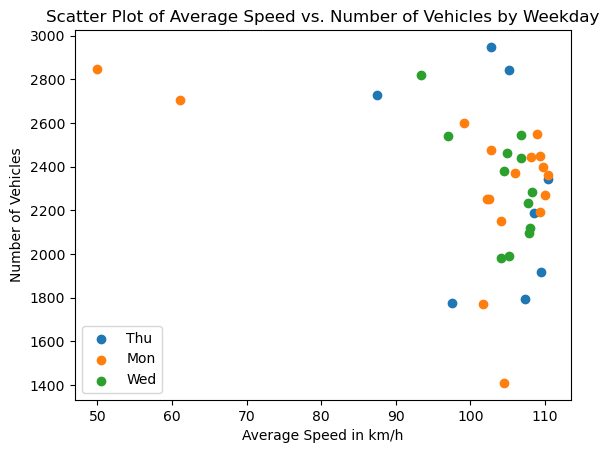

In [40]:
# This plotting shows the different traffic flow per weekday which as you can see some of the dots are far away from the ratio
# and considered as High Traffic. Whatever inside the pile of dots are medium and the rest are low traffic/
for i, day in enumerate(df['weekDay'].unique()):
    x = df[df['weekDay'] == day]['averageSpeed']
    y = df[df['weekDay'] == day]['numVehicles']
    plt.scatter(x, y, label=day)
plt.xlabel('Average Speed in km/h')
plt.ylabel('Number of Vehicles')
plt.title('Scatter Plot of Average Speed vs. Number of Vehicles by Weekday')
plt.legend()
plt.show()

In [41]:
# Calculating the range of speed to determine the times for the highest traffic jams.
NotSpeedRange = averageSpeed[(averageSpeed < MinSpeed) | (averageSpeed > MaxSpeed)]
lowSpeed = NotSpeedRange[NotSpeedRange< MinSpeed]
highSpeed = NotSpeedRange[NotSpeedRange> MaxSpeed]

In [42]:
# Result of when is has the highest traffic jam with speed, time, and number of cars.
highTrafficDays = df[df['averageSpeed'].isin(lowSpeed)]['weekDay']
highTrafficTime = df[df['averageSpeed'].isin(lowSpeed)]['startTime']
highTrafficSpeed = df[df['averageSpeed'].isin(lowSpeed)]['averageSpeed']
highTrafficNumV = df[df['averageSpeed'].isin(lowSpeed)]['numVehicles']
df_highTraffic = pd.concat([highTrafficDays, highTrafficTime, highTrafficSpeed, highTrafficNumV], axis=1)
for index, row in df_highTraffic.iterrows():
    print(f"In the weekday {row['weekDay']}, and the time {row['startTime']}, had higher than usual traffic with {row['numVehicles']} vehicles and an average speed of {row['averageSpeed']} km/h.")

In the weekday Thu, and the time 17:21, had higher than usual traffic with 2728 vehicles and an average speed of 87.457 km/h.
In the weekday Mon, and the time 08:55, had higher than usual traffic with 2850 vehicles and an average speed of 49.993 km/h.
In the weekday Mon, and the time 09:20, had higher than usual traffic with 2708 vehicles and an average speed of 61.094 km/h.


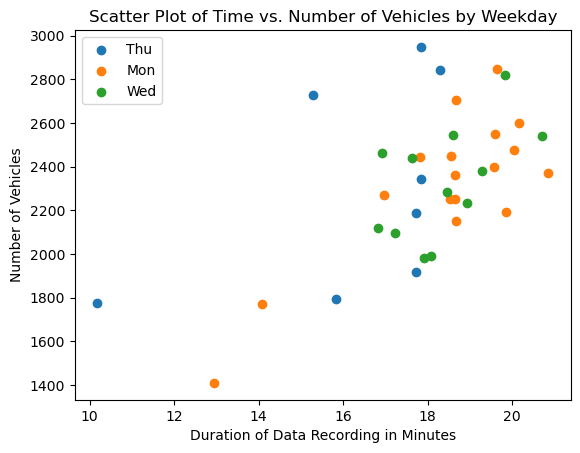

In [43]:
# Showing that how many cars are moving per minute by each weekday defined. These help us to see the flow of traffic per minute.
xCduration = df['duration']/60
yCnumVehicles = df['numVehicles']
for i, day in enumerate(df['weekDay'].unique()):
    x = df[df['weekDay'] == day]['duration']/60
    y = df[df['weekDay'] == day]['numVehicles']
    plt.scatter(x, y, label=day)
plt.xlabel('Duration of Data Recording in Minutes')
plt.ylabel('Number of Vehicles')
plt.title('Scatter Plot of Time vs. Number of Vehicles by Weekday')
plt.legend()
plt.show()
# Calculating the raio of Number of cars passing through the Autobahn image per minute.
ratio_TimeNum = yCnumVehicles/xCduration
mean_TimeNum = np.mean(ratio_TimeNum)
std_TimeNum = np.std(ratio_TimeNum)
df['ratioTimeNum'] = ratio_TimeNum
df.to_csv('output.csv', index=False)

In [44]:
# Getting the Maximum and Minimum Car Passing Ration using the mean and std diviasion.
MaxTN_Ratio = np.round(mean_TimeNum + std_TimeNum)
MinTN_Ratio = np.round(mean_TimeNum - std_TimeNum)

In [45]:
# This shows at what date and time, cars passing through the autobahn are less than average ratio. Meaning there is a traffic
# jam at these times.
NotTNL = ratio_TimeNum[(ratio_TimeNum < MinTN_Ratio)]
LTFDays = df[df['ratioTimeNum'].isin(NotTNL)]['weekDay']
LTFTime = df[df['ratioTimeNum'].isin(NotTNL)]['startTime']
LTFSpeed = df[df['ratioTimeNum'].isin(NotTNL)]['averageSpeed']
LTFNumV = df[df['ratioTimeNum'].isin(NotTNL)]['numVehicles']
df_LTF = pd.concat([LTFDays, LTFTime, LTFSpeed, LTFNumV], axis=1)
for index, row in df_LTF.iterrows():
    print(f"In the weekday {row['weekDay']}, and the time {row['startTime']}, had less cars passing throw in a minute with {row['numVehicles']} vehicles and an average speed of {row['averageSpeed']} km/h.")

In the weekday Mon, and the time 12:20, had less cars passing throw in a minute with 1410 vehicles and an average speed of 104.546 km/h.
In the weekday Wed, and the time 11:26, had less cars passing throw in a minute with 1992 vehicles and an average speed of 105.193 km/h.
In the weekday Wed, and the time 11:55, had less cars passing throw in a minute with 1984 vehicles and an average speed of 104.125 km/h.
In the weekday Mon, and the time 09:04, had less cars passing throw in a minute with 2191 vehicles and an average speed of 109.251 km/h.
In the weekday Thu, and the time 10:26, had less cars passing throw in a minute with 1919 vehicles and an average speed of 109.385 km/h.


In [46]:
# This shows at what date and time, cars passing through the autobahn are more than average ratio. Meaning there is no traffic
# jam at these times. So, the Autobahn is kind of empty at these times and travellers can use it to go home faster.
NotTNH = ratio_TimeNum[(ratio_TimeNum > MaxTN_Ratio)]
HTFDays = df[df['ratioTimeNum'].isin(NotTNH)]['weekDay']
HTFTime = df[df['ratioTimeNum'].isin(NotTNH)]['startTime']
HTFSpeed = df[df['ratioTimeNum'].isin(NotTNH)]['averageSpeed']
HTFNumV = df[df['ratioTimeNum'].isin(NotTNH)]['numVehicles']
df_HTF = pd.concat([HTFDays, HTFTime, HTFSpeed, HTFNumV], axis=1)
for index, row in df_HTF.iterrows():
    print(f"In the weekday {row['weekDay']}, and the time {row['startTime']}, had more cars passing throw in a minute with {row['numVehicles']} vehicles and an average speed of {row['averageSpeed']} km/h.")

In the weekday Thu, and the time 16:18, had more cars passing throw in a minute with 1776 vehicles and an average speed of 97.576 km/h.
In the weekday Thu, and the time 17:21, had more cars passing throw in a minute with 2728 vehicles and an average speed of 87.457 km/h.
In the weekday Thu, and the time 18:04, had more cars passing throw in a minute with 2949 vehicles and an average speed of 102.772 km/h.
In the weekday Thu, and the time 18:28, had more cars passing throw in a minute with 2844 vehicles and an average speed of 105.197 km/h.
